In [2]:
import pandas as pd
import datetime as dt
from google.colab import drive
from google.colab import files
import seaborn as sb
!pip install xlrd
import xlrd
import functools
import matplotlib.pyplot as plt
sb.set_style("darkgrid")
import sklearn
from scipy import stats




*   Group: Census Tract grouping (crime,demographic, landuse) -> Adi work on getting business data
*   Question: 
  * General Model for Philadelphia (Overall crime change and crime change by type) -**?**
  * Violent vs. Non-violent crimes over time (General Level) **Adi** 
  * Do neighboring census tracts share similar crime properties
   * Number of crimes in future (censustract level) by type - Count by unit time 
 
 Goal:
  * Simulate crime occurence and type within a census tract (analyze resulting simulation)
  
Moving Forward 12/6:


*   General Philly model does not make that much sense
*   Build seperate model for each census tract and look to incorporate monthly trends
*   Split each model into training and test set
*   See if there can be any sharing between models










In [0]:
## If Runtime dies this is the code to run


## reading in data files

#### Crime 
path = '/content/gdrive/My Drive/Python Final Project/Datasets/'
county_dens = pd.read_csv(path + 'PCounty_Dens.txt',sep='\t')
crime = pd.read_csv(path +'PCrime_Original.txt',sep='\t')
crime.timedate = pd.to_datetime(crime.timedate)
crime['Year'] = [x.year for x in crime.timedate]
crime['Month'] = [x.month for x in crime.timedate]

#### Landuse
landuse = pd.read_csv(path + 'LanduseFiltered.txt',sep='\t')
landuse['block'] = landuse['block'].fillna(0)
landuse['block'] = landuse['block'].astype(int)

#### Demographic Data 
dec = pd.read_excel(path + 'deccentenial_101.xlsx',sep='\t')
newCols =  ['BLOCK', 'BLKGRP', 'TRACT', 'total', 'white', 'black', 'us_indian', 'asian', 'pacific', 'other', 'two_or_more', 'hispanic','state', 'county', 'tract', 'block']
dec.columns = newCols
###### Clean NA and Drop Duplicates **** Explore later when more time
posTotal = dec[dec.total>0]
posUnique = posTotal.drop_duplicates('BLOCK')

## ACS
acs = pd.read_excel(path + 'ACS_DATA.xlsx',sep='\t')


## Get Landuse and Crime on tracts 
#blockTract = crime[['block','censustract']]
#landuseTract = pd.merge(landuse,blockTract,on='block')

## Build Primary Index 
crime['YearMonth'] = [str(x) + '_' + str(y) for x,y in zip(crime.Year,crime.Month)]

yearChosen = 2011

## Filter for year ? - make data more manageable for quick analysis
#landuseY = landuseTract[landuseTract.year == yearChosen]

## Filter for year ? for crime - 

crimeY = crime[crime.Year == yearChosen]

## 1st Merge landuse and dec and clean
decLanduse = pd.merge(posUnique,landuse,on='block',how='inner')

def parseAgg(obj,series):
  selectEl = series[series ==obj]
  return len(selectEl)

#******** Can Explore Use_detail if simple is useful ********
useSimpleNames = set(decLanduse.use_simple)
collection = pd.DataFrame(decLanduse.groupby('block').tract.count())
for name in useSimpleNames:
  parseData = decLanduse.groupby('block').agg({'use_simple': [functools.partial(parseAgg,name)]})
  collection = pd.concat([collection,parseData],axis = 1)

collection.columns = ['blockGroupNumber'] + list(useSimpleNames)
collection = pd.concat([collection,decLanduse.groupby('block').area.sum()],axis=1)

# *** drop certain columns check later
filDL = decLanduse.drop(['BLKGRP','state','county','TRACT', 'use_simple','use_detail','use_color','area'],axis=1)
filDL = filDL.drop_duplicates('block')
DLblockLevel = pd.merge(filDL,collection.reset_index(),on='block')

## 2nd Merge decLanduse and crime12
# **** problem missing/ not including data because we don't have that much data in ACS or landuse
# **** Can better improve by adding missing column

TotalDf = pd.merge(crime,DLblockLevel,on='block')

##*** primary key YearTract *** does not work 
TotalDf['YearTract'] = [str(x) + '_' + str(y) for x,y in zip(TotalDf.Year,TotalDf.tract)]

###### Add columns
crimeNames = list(set(TotalDf.crime_cat))
holder = pd.DataFrame(TotalDf.groupby('YearTract').tract.count())
for name in crimeNames:
  parseData = TotalDf.groupby('YearTract').agg({'crime_cat': [functools.partial(parseAgg,name)]})
  holder = pd.concat([holder,parseData],axis = 1)
holder.columns = ['Y'] + crimeNames

#### Filter out columns
TotalDfFil = TotalDf.drop(['date','time','ucr','crime_cat','long','lat', \
                           'crimetype','timedate','weekday','block','BLOCK','Year',\
                           'Month','blockgroup','censustract','blockGroupNumber'],axis=1)

## Fully Merged Dataframe 
DataYearTract = pd.merge(TotalDfFil.groupby('YearTract').sum().reset_index(),holder.reset_index(),on='YearTract')
DataYearTract['year'] = [int(x[0:4]) for x in DataYearTract.YearTract]



## Try: YearMonth
crimeNames = list(set(TotalDf.crime_cat))
holder = pd.DataFrame(TotalDf.groupby('YearMonth').tract.count())
for name in crimeNames:
  parseData = TotalDf.groupby('YearMonth').agg({'crime_cat': [functools.partial(parseAgg,name)]})
  holder = pd.concat([holder,parseData],axis = 1)
holder.columns = ['Y'] + crimeNames

#***** how to aggregate other columns??
DataYearMonth = pd.merge(TotalDfFil.drop_duplicates('YearMonth'),holder.reset_index(),on='YearMonth')

# *** quick fix
def modeSeries(series):
  return stats.mode(series)[0]
TractSum = TotalDfFil.groupby('tract').sum().reset_index()
TractTotal = pd.merge(TotalDfFil.groupby('YearMonth').agg({'tract':modeSeries}).reset_index(),TractSum,on='tract')
#DataYearMonthMax = pd.merge(TractTotal,holder.reset_index(),on='YearMonth')
#DataYearMonthMax['year'] = [int(x[0:4]) for x in DataYearTract.YearMonth]
#DataYearMonthMax['month'] = [int(x[6:]) for x in DataYearTract.YearMonth]


In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## Visualizations
crime.head()
crime_type = crime.groupby('crime_cat').count()
sb.barplot(crime_type.index,crime_type.date).set_title('Crime Types by Number')
crimeYears = crime.groupby('Year').count()
sb.barplot(crimeYears.index,crimeYears.date).set_title('Number of Crime by Year')
crime.sort_values('block').drop_duplicates('block')
crime.groupby('censustract').count()

## Year Month Viz
plt.plot(TotalDf.groupby('YearMonth').count()['time'])
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Crime Types by Number')

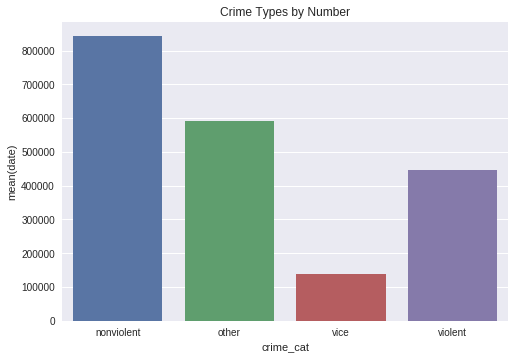

In [0]:
crime_type = crime.groupby('crime_cat').count()
sb.barplot(crime_type.index,crime_type.date).set_title('Crime Types by Number')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Overall Number of Crime by Year')

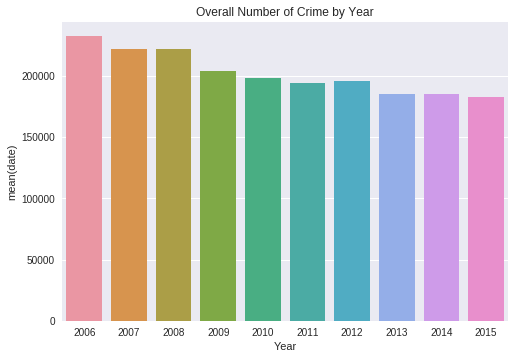

In [7]:
crimeYears = crime.groupby('Year').count()
sb.barplot(crimeYears.index,crimeYears.date).set_title('Overall Number of Crime by Year')

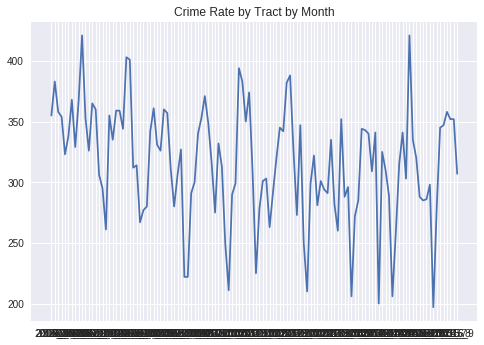

In [6]:
plt.plot(TotalDf.groupby('YearMonth').count()['time'])
plt.title('Crime Rate by Tract by Month')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Number of Violent Crime by Year')

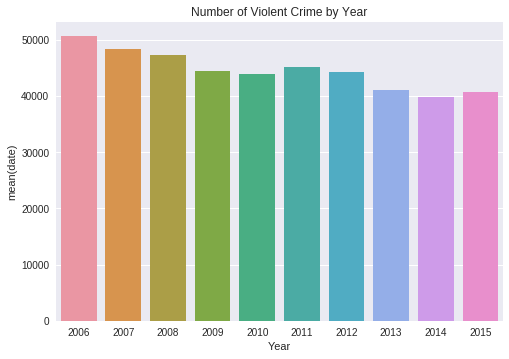

In [8]:
## Visualizations number of crimes by type
## Violent
crimeYears = crime[crime.crime_cat == 'violent'].groupby('Year').count()
sb.barplot(crimeYears.index,crimeYears.date).set_title('Number of Violent Crime by Year')


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Number of Non-Violent Crime by Year')

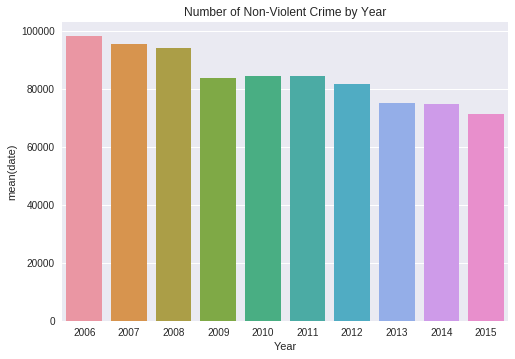

In [12]:
##Non-violent
crimeYears = crime[crime.crime_cat == 'nonviolent'].groupby('Year').count()
sb.barplot(crimeYears.index,crimeYears.date).set_title('Number of Non-Violent Crime by Year')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Number of Other Crime by Year')

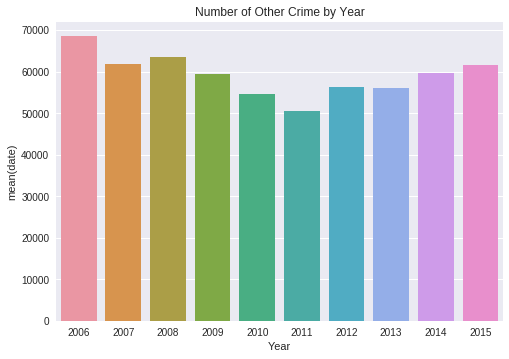

In [11]:
## Other 
crimeYears = crime[crime.crime_cat == 'other'].groupby('Year').count()
sb.barplot(crimeYears.index,crimeYears.date).set_title('Number of Other Crime by Year')

In [0]:
## Analytics
from sklearn.linear_model import LinearRegression
### train and test split
n = DataYearTract.shape[0]
Xtrain = DataYearTract.drop(['YearTract','Y'],axis=1)[:round(0.7 * n)]
Ytrain = DataYearTract.Y[:round(0.7 * n)]
Xtest =  DataYearTract.drop(['YearTract','Y'],axis=1)[round(0.7 * n):]
Ytest =  DataYearTract.Y[round(0.7 * n):]

### 3 Models 






In [0]:
acs = pd.read_excel(path + 'ACS_DATA.xlsx',sep='\t')

In [0]:
landuse = pd.read_csv(path + 'LanduseFiltered.txt',sep='\t')

In [0]:
crime.head()

In [0]:
crime.shape

In [0]:
## Steps
## Max tract

TotalDfFil.columns

In [0]:
DataYearMonthMax.head()

In [0]:
DataYearMonthMax[['residential','vacant_other']]

In [0]:
holder.head()

In [0]:
DataYearMonthMax.to_csv(path + 'DataYearMonthMax.csv')